# <img src="https://uxwing.com/wp-content/themes/uxwing/download/business-professional-services/boy-services-support-icon.png" style="height: 40px"/> MLRun's Call Center Demo

## Notebook 2: Data Analysis:

Welcome to Iguazio Internet company's call center. This demo showcases how to use GenAI to analyze calls, turning call center audio files of customers and agents into valuable data, all in one single workflow orchestrated by MLRun.

MLRun automates the entire workflow, auto-scales resources as needed, automatically distributes inference jobs to multiple workers, and automatically logs and parses values between the different workflow steps.

The demo demonstrates two usages of GenAI:
* **Unstructured Data Generation** &mdash; Generating audio data with ground truth metadata to evaluate the analysis.
* **Unstructured Data Analysis** &mdash; Turning audio calls into text and tabular features.

## Table of contents:

1. [Get the project](#get_the_project)
2. [Calls analysis](#calls_analysis)
3. [View the data](#view_the_data)
4. [Future work](#future_work)

___
<a id="get_the_project"></a>
## Get the project 

- This demo is limited to run with MLRun 1.9.x Python 3.11, with CPU, and run the pipeline with `engine = "remote"`.
- GPU is not supported at the moment.
- Please set `run_with_gpu = False`, `engine = "remote"`
- .env include OPENAI_API_KEY, OPENAI_API_BASE

#### Setup in Platform McK

- GPU is not supported at the moment.
- sqlite is supported.
- Please set `run_with_gpu = False`, `engine = "remote"`
- .env include OPENAI_API_KEY, OPENAI_API_BASE, and S3_BUCKET_NAME

### Fill the tokens and URL

> **⚠️ Important** Please fill the following variables in your `.env` file.

Tokens are required to run the demo end-to-end:
* [OpenAI ChatGPT](https://chat.openai.com/) &mdash; To generate conversations, two tokens are required:
  * `OPENAI_API_KEY`
  * `OPENAI_API_BASE`

For Platform Mck, a s3 bucket name needs to be in the `.env`
* [S3 Bucket]() &mdash; 
  * `S3_BUCKET_NAME`

In [1]:
# True = run with GPU, False = run with CPU
run_with_gpu = False
language = "en" # The languages of the calls, es - Spanish, en - English

In [2]:
import dotenv
import os
import sys
import mlrun
dotenv_file = ".env"
sys.path.insert(0, os.path.abspath("./"))

dotenv.load_dotenv(dotenv_file)

True

In [3]:
assert not run_with_gpu
assert os.environ["OPENAI_API_BASE"]
assert os.environ["OPENAI_API_KEY"]

###  Get the current project

The MLRun project is created by running the function [`mlrun.get_or_create_project`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.get_or_create_project). This creates the project (or loads it if previously created) and sets it up automatically according to the [project_setup.py](./project_setup.py) file located in this repo. 

The project_setup.py file sets the functions according to the following default `parameters`. You can adjust them as relevant:

* `source : str` &mdash; The git repo source of the project to clone when each function is running.
* `default_image : str` &mdash; The default image to use for running the workflow's functions. For the sake of simplicity, the demo uses the same image for all the functions.
* `gpus: int` &mdash; The number of GPUs to use when running the demo. 0 means CPU.
* `node_selector: Dict[str, str]` &mdash; The node selector to use when running the demo (optional).
* `node_name: str` &mdash; The node name to run the demo on (optional).

> Note: Multiple GPUs (`gpus` > 1) automatically deploy [OpenMPI](https://www.open-mpi.org/) jobs for **better performance and GPU utilization**.

There are not many functions under the source directory. That's because most of the code in this project is imported from [**MLRun's Function hub**](https://www.mlrun.org/hub/) &mdash; a collection of reusable functions and assets that are optimized and tested to simplify and accelerate the move to production!

In [4]:
project_name="call-center-demo"
project = mlrun.get_or_create_project(
    name=project_name,
    user_project=False,
    allow_cross_project=True,
    parameters={
        "build_image": False,
        "source": "git://github.com/xsqian/demo-call-center.git#main",
        "gpus": 1 if run_with_gpu else 0,
        "use_sqlite": True,
        "default_image": f'.mlrun-project-image-{project_name}',
        "skip_calls_generation": True
    },
)

default image from the get_param: .mlrun-project-image-call-center-demo
Project Source: git://github.com/xsqian/demo-call-center.git#main
set default image to : .mlrun-project-image-call-center-demo
set wotkflow with image to: .mlrun-project-image-call-center-demo
set wotkflow with image to: .mlrun-project-image-call-center-demo
> 2026-01-13 02:04:33,161 [info] Project loaded successfully: {"project_name":"call-center-demo"}


___
<a id="calls_analysis"></a>
## 3. Calls analysis

The workflow includes multiple steps for which all of the main functions are imported from the **[MLRun Function Hub](https://www.mlrun.org/hub/)**. You can see each hub function's docstring, code, and example, by clicking the function name in the following list:

1. [**Insert the Calls Data to the DB**](./src/calls_analysis/db_management.py) &mdash; Insert the calls metadata to the MySQL DB.
2. [**Perform Speech Diarization**](https://github.com/mlrun/functions/tree/development/silero_vad) &ndash; ***Hub Function***: Analyze when each person is talking during the call for subsequent improved transcription and analysis. Diarization gives context to the LLM and yields better results. The function uses the [silero-VAD](https://github.com/snakers4/silero-vad) model. The speech diarization is performed per channel based on the assumption that each channel of the audio in the call center recordings belongs to a different speaker.
3. [**Transcribe**](https://github.com/mlrun/functions/tree/master/transcribe) &ndash; ***Hub function***: Uses [Huggingface's ASR pipeline](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.AutomaticSpeechRecognitionPipeline) with [OpenAI's Whisper models](https://huggingface.co/openai).This function transcribes and translates the calls into text and saves them as text files. It is an optimized version of [OpenAI's Whisper](https://openai.com/research/whisper) package &mdash; enabled to use batching, CPU offloading to multiprocessing workers, and to distribute across multiple GPUs using MLRun and OpenMPI.
4. [**Recognize PII**](https://github.com/mlrun/functions/tree/master/pii_recognizer) &ndash; ***Hub Function***: Uses three techniques to recognize personally identifiable information: RegEx, [Flair](https://flairnlp.github.io/) and [Microsoft's Presidio Analyzer](https://microsoft.github.io/presidio/analyzer/) and [Anonymizer](https://microsoft.github.io/presidio/anonymizer/). The function clears the recognized personal data and produces multiple artifacts to review and understand the recognition process.
5. [**Analysis**](https://github.com/mlrun/functions/tree/master/question_answering) &ndash; ***Hub Function***: Uses an LLM to analyze a given text. It expects a prompt template and questions to send to the LLM, and then constructs a dataframe dataset from its answers. This demo uses a GPTQ quantized version of [Mistral-7B](https://huggingface.co/TheBloke/Mistral-7B-OpenOrca-GPTQ) to analyze the calls' conversations. It helps to extract the following features:
   
   * `topic: str` &mdash; The general subject of the call out of a given list of topics.
   * `summary: str` &mdash; The summary of the entire call in few sentences.
   * `concern_addressed: bool` &mdash; Whether the client's concern was addressed at the end of the call. Can be one of {yes, no}.
   * `customer_tone: str` &mdash; The general customer tone during the call. Can be one of {positive, neutral, negative}.
   * `agent_tone: str` &mdash; The general agent tone during the call. Can be one of {positive, neutral, negative}.   
   * `upsale_attempted: bool` &mdash; Whether the agent tried to upsell the client during the call.
   * `upsale_success: bool` - Whether the upsell attempt was successful.
   * `empathy: int` &mdash; The level of empathy on the part of the agent from 1 to 5.
   * `professionalism: int` &mdash; The agent's professionalism from 1 to 5.
   * `kindness: int` &mdash; How kind was the agent from 1 to 5.
   * `effective_communication: int` &mdash; Efficacy of the agent's communication from 1 to 5.
   * `active_listening: int` &mdash; The level of active listening on the part of the agent from 1 to 5.
   * `customization: int` &mdash; How closely the agent responded to the client's needs from 1 to 5.

6. [**Postprocess Analysis Answers**](./src/postprocess.py) - A project function used to postprocess the LLM's answers before updating them into the DB.
 
Between each step, there is a call for the function [**Update Calls**](./src/calls_analysis/db_management.py) that updates the calls DB with the newly collected data and status.

Here you can see an example of a call row in the database before and after the analysis:

* In the beginning of the workflow:
| Call ID   | Client ID | Agent ID | Date      | Time    | Audio File |
| :-------- | :-------- | :------- | :-------- | :------ | :--------- |
|123456     | 123456    |AG123     |2023-10-30 |14:12:17 |123.wav     |

* After the workflow Completion:
| Call ID   | Client ID | Agent ID | Date      | Time    | Status  | Audio File | Transcription File | Anonymized File | Topic     | Summary  | Concern Addressed | Client Tone | Agent Tone | Upsale Attempted | Upsale Success | Empathy | Professionalism | Kindness | Effective Communication | Active Listening | Customization |
| :-------- | :-------- | :------- | :-------- | :------ | :------ | :--------- | :----------------- | :-------------- | :-------- | :------- | :---------------: | :---------: | :--------: | :--------------: | :------------: | :-----: | :-----------: | :-------: | :---------------------: | :------------------: | :-----------: |
|123456     | 123456    |AG123     |2023-10-30 |14:12:17 |Analyzed |123.wav     |123.txt             |123.txt.         |Some topic |A summary |True               |Positive.    |Positive.   |False             |True            |3        |4              |5          |4                        |3                      |4              || :--------- | :-------- |

### 3.1. Run the workflow

Now, run the workflow using the following parameters:
* `batch: str` &mdash; Path to the dataframe artifact that represents the batch to analyze. 
* `calls_audio_files : str` &mdash; Path to the conversation audio files directory or a given input batch.

> Notice: The `batch` and  the `calls_audio_files` are passed to the workflow using the artifact's store paths. 
* `batch_size: int` &mdash; The batch size for the transcription's inference model (size for each worker).
* `transcribe_model : str` &mdash; The model to use for the transcribe function. Must be one of the official model names listed [here](https://github.com/guillaumekln/faster-whisper).
* `translate_to_english: bool` &mdash; Whether to translate the transcriptions to English. Recommended for use when the audio language is not English.
* `pii_recognition_model : str` &mdash; The model to use. Can be "spacy", "flair", "pattern" or "whole".
* `pii_recognition_entities : Listr[str]` &mdash; The list of entities to recognize.
* `pii_recognition_entity_operator_map: Dict[str, tuple]` &mdash; A dictionary that maps entity to operator name and operator params.
* `question_answering_model : str` &mdash; The model to use for answering the given questions.
* `insert_calls_db: bool` If False, Skip insert calls step and use the existing calls in the MySQL table

> 2026-01-13 02:04:33,168 [info] Submitting remote workflow: {"project_name":"call-center-demo","schedule":null,"workflow_engine":"kfp"}


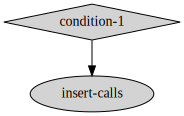

> 2026-01-13 02:04:44,928 [info] Started run workflow call-center-demo-calls-analysis with run id = '27fdf698-684e-4c4e-8602-bb42dd51fd83' by remote engine
> 2026-01-13 02:04:44,929 [info] Waiting for pipeline run completion: {"project":"call-center-demo","run_id":"27fdf698-684e-4c4e-8602-bb42dd51fd83"}


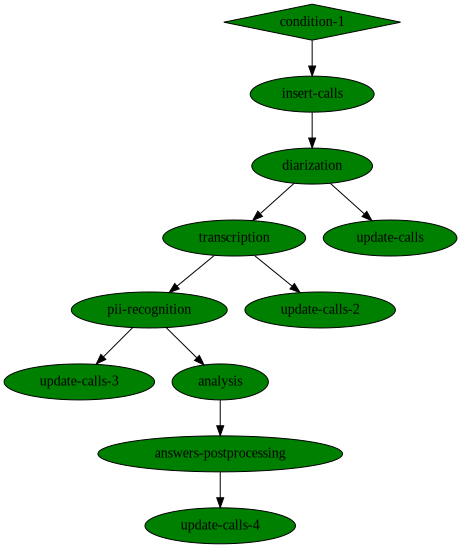

In [5]:
workflow2_run = project.run(
    name="calls-analysis",
    arguments={
        "batch": project.get_artifact_uri("batch-creation_calls_batch"),
        "calls_audio_files": project.get_artifact_uri("text-to-audio_audio_files"),
        "batch_size": 2,
        "transcribe_model": "openai/whisper-tiny" if not run_with_gpu else "openai/whisper-large-v3",
        "translate_to_english": True,
        "pii_recognition_model": "whole",
        "pii_recognition_entities": ['PERSON', "EMAIL", "PHONE"],
        "pii_recognition_entity_operator_map": {
            "PERSON": ("replace", {"new_value": "John Doe"}),
            "EMAIL": ("replace", {"new_value": "john_doe@email.com"}),
            "PHONE": ("replace", {"new_value": "123456789"}),
        },
        "question_answering_model": "Qwen/Qwen2.5-1.5B-Instruct" if not run_with_gpu else "TheBloke/Mistral-7B-OpenOrca-GPTQ",
        "auto_gptq_exllama_max_input_length": None if not run_with_gpu else 8192,
        "insert_calls_db": True,
    },
    watch=True,
    dirty=True,
    timeout=60 * 240,
    engine="remote"
)

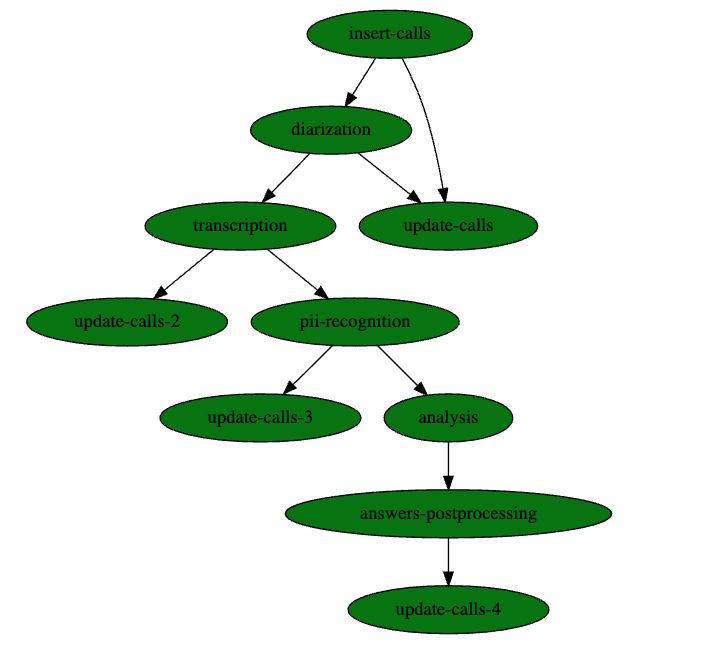

___
<a id="view_the_data"></a>
## 4. View the data

While the workflow is running, you can view the data and features as they are collected.

> Note: Since each step in the workflow is automatically logged, it can also be viewed in the MLRun UI under the project's artifacts. MLRun's experiment tracking enables full exploration and reproducibility between steps in a workflow due to its automatic logging features. 

In [6]:
import zipfile

# Download to temp directory:
for artifact_name, target_path in [
    ("text-to-audio_audio_files", "audio_files"),
    ("conversation-generation_conversations", "anonymized_files"),
]:
    temp_path = project.get_artifact(artifact_name).to_dataitem().local()
    with zipfile.ZipFile(temp_path, 'r') as zip_ref:
        zip_ref.extractall(f"./outputs/{target_path}")

> 2026-01-13 02:39:52,388 [info] downloading v3io:///projects/call-center-demo/artifacts/5e93bdc2-415f-4033-9d1f-3e2d7416cc56/text-to-audio/0/audio_files.zip to local temp file
> 2026-01-13 02:39:53,522 [info] downloading v3io:///projects/call-center-demo/artifacts/5e93bdc2-415f-4033-9d1f-3e2d7416cc56/conversation-generation/0/conversations.zip to local temp file


Here we deploy our [**Vizro**](https://vizro.mckinsey.com/) application to visualize the data in the DB. The application is deployed using the application runtime.
After running the following cell, you can view the data in the Vizro application by clicking on the output link.

In [7]:
from src.vizro import deploy_vizro_application

deploy_vizro_application()

Application source code ready for deployment.
Configuring V3IO v3io:///users/xingsheng/demo-call-center-new/vizro.tar.gz to UI
> 2026-01-13 02:45:38,216 [info] Started building image: .mlrun/cst-360func-call-center-demo-call-center-ui:latest
INFO[0000] Retrieving image manifest python:3.11        
INFO[0000] Retrieving image python:3.11 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest python:3.11        
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'python:3.11' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd ADD vizro.tar.gz /home/mlrun_code/ requires it. 
INFO[0016] ARG CONTAINER=$CONTAINER                     
INFO[0016] ARG DBPATH=$DBPATH                           
INFO[0016] ARG MYSQL_URL=$MYSQL_URL                     
INFO[0016] ARG OPENAI_API_BASE=$OPENAI_API_BASE         
INFO[0016] ARG OPENAI_

### The Application UI

![Vizro Application UI](images/call-center-ui.png)

___
<a id="future_work"></a>
## 5. Future work

This demo is a proof of concept for LLM's feature-extraction capabilities, while using MLRun for the orchestration from development to production. The demo continues to be developed. You are welcome to track and develop it with us:

### v0.3
#### New features
* [ ] **Open Source Data Generation Workflow** - Replace OpenAI ChatGPT with an open-source LLM.
* [ ] **Data Storage** - Generated data files will be uploaded into a data storage like S3.
* [ ] **Evaluation** - Perform evaluation based on the ground truth generated along the data to assess the transcription quality and the LLM analysis accuracy.
* [ ] **Milvus as Vector DB** - PII free transcription will be saved in a Milvus DB for further data analysis and application features.
* [ ] **Data Analysis Workflow** - Workflow to analyze the collected data from the RDB (MySQL) and VDB (Milvus).

### v0.2
#### New features
* [x] **Calls Generation Pipeline** - Generate data and a batch of calls with ground truth metadata for evaluation.
* [x] **MySQL as Relational DB** - Store all the collected analysis and data in a MySQL database.
* [x] **Speech Diarization** - Know who talks when by performing speech diarization per channel.
* [x] **Translation** - Enable translating the transcriptions into English for inferring through the open source LLM.

#### Improvements
* [x] **Distributed Transcription and Diarization** - Add OpenMPI support to distribute the pipeline functions across multiple workers.
* [x] **Batched Inference** - Use batches for better GPU utilization for both the analysis and transcription.
* [x] **Mistral-7B Instead of Falcon-40B** - Use a newer and smaller model for better results and faster inference.
* [x] **GPTQ Quantization** - Use a GPTQ quantized model for analysis for faster inference time.

### v0.1
* [x] **Transcription** - Use Open AI's Whisper for transcribing audio calls.
* [x] **Anonymization** - Anonymize the text before inferring.
* [x] **Analysis** - Perform question answering for feature extraction using Falcon-40B.